In [1536]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score, mean_absolute_percentage_error

In [1537]:
# Importing the dataset
df_iot = pd.read_csv('projeto8-data_files/projeto8-training.csv')
GRAPHS = False

In [1538]:
# taking a look at the data
df_iot.head(5)

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,NSM,WeekStatus,Day_of_week
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,61200,Weekday,Monday
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,61800,Weekday,Monday
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,62400,Weekday,Monday
3,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,63600,Weekday,Monday
4,2016-01-11 17:50:00,50,40,19.89,46.026667,19.2,44.500000,19.79,44.933333,18.890000,...,734.0,92.0,5.333333,43.833333,4.8,44.919484,44.919484,64200,Weekday,Monday


In [1539]:
# Verifying missing values
df_iot.isnull().sum().sum()

0

In [1540]:
# Verifying duplicates
df_iot.duplicated().sum()

0

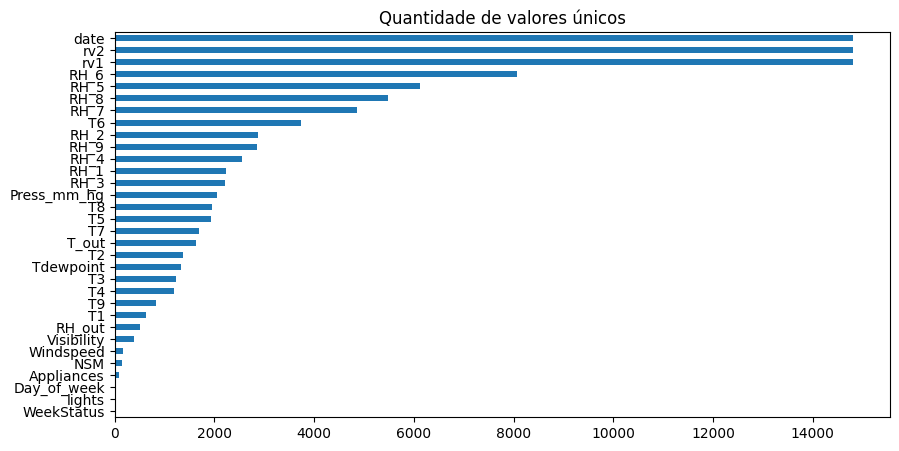

In [1541]:
# Verifying the number of unique values in each column
df_iot.nunique().sort_values().plot(kind='barh', figsize=(10, 5))
plt.title('Quantidade de valores únicos')
plt.show()

In [1542]:
# let us wipe out random variables, rv1 and rv2, as well as 'Day_of_week' and 'WeekStatus'
df_iot.drop(['rv1', 'rv2', 'Day_of_week', 'WeekStatus'], axis=1, inplace=True)

In [1543]:
# Verifying negative values in the dataset
mask_negativos = (df_iot.describe().T['min'].values<0)
cols_negativos = list(df_iot.describe().T['min'][mask_negativos].index)

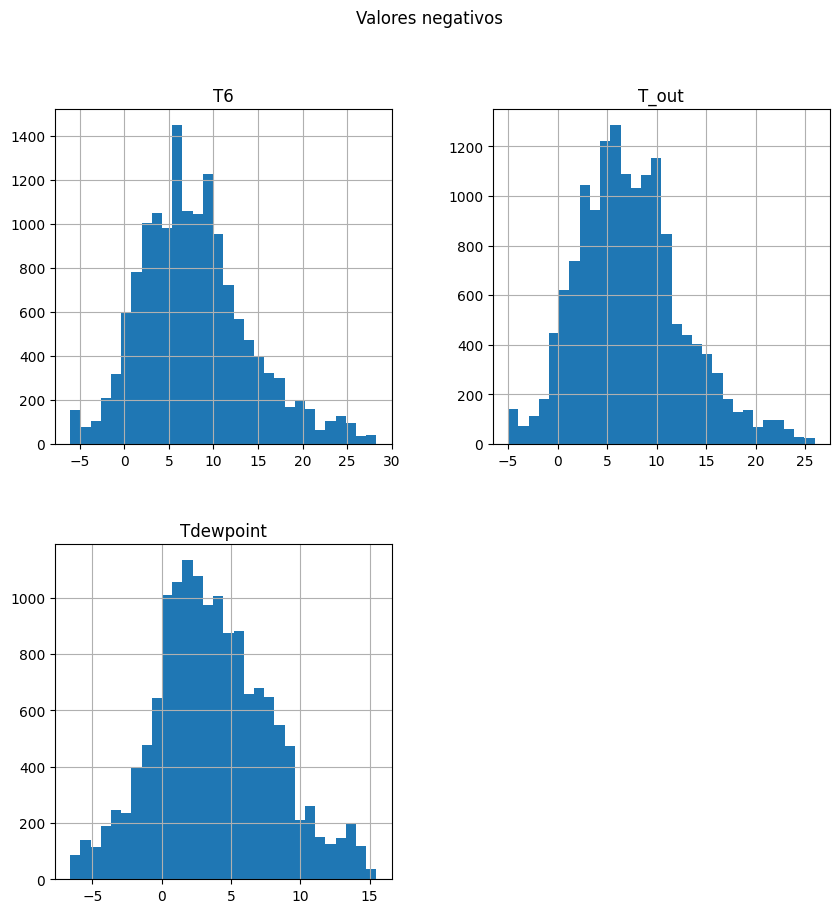

In [1544]:
# Plotting the negative values
df_iot[cols_negativos].hist(figsize=(10, 10), bins=30)
plt.suptitle('Valores negativos')
plt.show()

In [1545]:
# Describing the negative values
df_iot[cols_negativos].describe().T

,count,mean,std,min,25%,50%,75%,max
T6,14803.0,7.921003,6.103785,-6.065,3.656667,7.295,11.245000,28.290000
T_out,14803.0,7.413018,5.323843,-5.000,3.666667,6.900,10.400000,25.966667
Tdewpoint,14803.0,3.756859,4.200297,-6.600,0.900000,3.450,6.533333,15.500000


In [1546]:
# rows with negative values
df_iot[cols_negativos].loc[df_iot[cols_negativos].lt(0).any(axis=1)]

,T6,T_out,Tdewpoint
224,7.433333,6.400000,-0.100000
225,7.156667,6.166667,-0.066667
226,7.030000,5.933333,-0.033333
353,4.190000,3.800000,-0.233333
354,4.300000,3.900000,-0.616667
...,...,...,...
12413,19.200000,17.400000,-0.500000
12414,19.226667,17.466667,-1.100000
12415,19.566667,17.500000,-1.400000
12416,19.533333,18.133333,-0.666667


In [1547]:
if GRAPHS:
    # plotting histograms for the features
    df_iot.hist(figsize=(12, 12), bins=30)
    plt.suptitle('Valores negativos')
    plt.tight_layout()
    plt.show()

In [1548]:
# transforming 'date' to datetime
df_iot['date'] = pd.to_datetime(df_iot['date'])

In [1549]:
# plotting the Energy consumption by date, filtered by type of lights, and resampled over 1 day and averaged
if GRAPHS:
    for light in df_iot['lights'].unique():
        plt.title('Energy consumption by date, filtered by type of lights')
        df_iot[df_iot['lights']==light].reset_index(drop=True).dropna().set_index('date')['Appliances'].resample('D').mean().plot(figsize=(15, 5), label='light '+str(light))
        plt.legend()
        plt.show()

In [1550]:
if GRAPHS:
    # data distribution for each type of light
    for light in df_iot['lights'].unique():
        df_iot[df_iot['lights']==light].reset_index(drop=True).dropna().set_index('date').resample('D').mean().hist(figsize=(15, 5), bins=30, label='light '+str(light))
        plt.tight_layout()
        plt.title(f'Data distribution by type of light {light}')
        plt.legend()
        plt.show()


In [1551]:
# let us begin by modeling just 'lights' == 0
#df_iot = df_iot[df_iot['lights']==0]
#df_iot = df_iot[df_iot['lights'].isin([0,10,20])]

#df_iot.drop('lights', axis=1, inplace=True)

In [1552]:
# Printing the columns of the dataset
list(df_iot.columns)

['date',
 'Appliances',
 'lights',
 'T1',
 'RH_1',
 'T2',
 'RH_2',
 'T3',
 'RH_3',
 'T4',
 'RH_4',
 'T5',
 'RH_5',
 'T6',
 'RH_6',
 'T7',
 'RH_7',
 'T8',
 'RH_8',
 'T9',
 'RH_9',
 'T_out',
 'Press_mm_hg',
 'RH_out',
 'Windspeed',
 'Visibility',
 'Tdewpoint',
 'NSM']

In [1553]:
df_iot_std = df_iot.copy()
df_iot_median = df_iot.copy()
df_iot_iqr = df_iot.copy()
df_iot = df_iot.set_index('date').resample('D').mean()
# do the for the standard deviation
df_iot_std = df_iot_std.set_index('date').resample('D').std()
# renaming the columns
df_iot_std.columns = [col+'_std' for col in df_iot_std.columns]
# concatenating the mean and std
#df_iot = pd.concat([df_iot, df_iot_std], axis=1)
# do the for the standard deviation
df_iot_median = df_iot_median.drop(columns=['Appliances']).set_index('date').resample('D').median()
# renaming the columns
df_iot_median.columns = [col+'_median' for col in df_iot_median.columns]
# concatenating the mean and std
#df_iot = pd.concat([df_iot, df_iot_median], axis=1)
# do the same for interquartile range
df_iot_iqr = df_iot_iqr.drop('Appliances',axis=1).set_index('date').resample('D').quantile(0.75) - df_iot_iqr.drop('Appliances',axis=1).set_index('date').resample('D').quantile(0.25)
# renaming the columns
df_iot_iqr.columns = [col+'_iqr' for col in df_iot_iqr.columns]
# concatenating the mean and std
df_iot = pd.concat([df_iot, df_iot_iqr,df_iot_std,df_iot_median], axis=1)

In [1554]:
len(df_iot)

138

In [1555]:
df_iot_std.isnull().sum().sum()

0

In [1556]:
df_iot_iqr.isnull().sum().sum()

0

In [1557]:
df_iot.isnull().sum().sum()

0

In [1558]:
if GRAPHS:
  cols_numeric1 = list(['T1','RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9',])

  # Cria um grid com quatro linhas e três colunas
  nrows = 5
  ncols = 4

  fig, axes = plt.subplots(nrows, ncols, figsize=(16,10))
  plt.subplots_adjust(wspace=0.2,hspace=0.2)

  # Itera pelo grid plotando os gráficos
  idx = 0
  for row in range(nrows):
    for col in range(ncols):
      try:
        ax = axes[row, col]
        sns.violinplot(y=df_iot[cols_numeric1[idx]],data=df_iot,
                      ax=ax,cut=0,color='blue')
        plt.tight_layout()
        ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
      except:
        ax.set_visible(False)
      idx += 1
  plt.show()

In [1559]:
if GRAPHS:
  cols_numeric1 = list(['T1','RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9',])

  # Cria um grid com quatro linhas e três colunas
  nrows = 5
  ncols = 4

  fig, axes = plt.subplots(nrows, ncols, figsize=(16,10))
  plt.subplots_adjust(wspace=0.2,hspace=0.2)

  # Itera pelo grid plotando os gráficos
  idx = 0
  for row in range(nrows):
    for col in range(ncols):
      try:
        ax = axes[row, col]
        sns.boxplot(y=df_iot[cols_numeric1[idx]],data=df_iot,
                      ax=ax,color='blue')
        plt.tight_layout()
        ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
      except:
        ax.set_visible(False)
      idx += 1
  plt.show()

In [1560]:
if GRAPHS:
  cols_numeric2 = list(['T_out','Press_mm_hg','RH_out','Windspeed','Visibility','Tdewpoint','NSM'])

  # Cria um grid com quatro linhas e três colunas
  nrows = 3
  ncols = 3

  fig, axes = plt.subplots(nrows, ncols, figsize=(16,10))
  plt.subplots_adjust(wspace=0.2,hspace=0.2)

  # Itera pelo grid plotando os gráficos
  idx = 0
  for row in range(nrows):
    for col in range(ncols):
      try:
        ax = axes[row, col]
        sns.violinplot(y=df_iot[cols_numeric2[idx]],data=df_iot,
                      ax=ax,cut=0,color='blue')
        plt.tight_layout()
        ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
      except:
        ax.set_visible(False)
      idx += 1
  plt.show()

In [1561]:
if GRAPHS:
  cols_numeric2 = list(['T_out','Press_mm_hg','RH_out','Windspeed','Visibility','Tdewpoint','NSM'])

  # Cria um grid com quatro linhas e três colunas
  nrows = 3
  ncols = 3

  fig, axes = plt.subplots(nrows, ncols, figsize=(16,10))
  plt.subplots_adjust(wspace=0.2,hspace=0.2)

  # Itera pelo grid plotando os gráficos
  idx = 0
  for row in range(nrows):
    for col in range(ncols):
      try:
        ax = axes[row, col]
        sns.boxplot(y=df_iot[cols_numeric2[idx]],data=df_iot,
                      ax=ax,color='blue')
        plt.tight_layout()
        ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
      except:
        ax.set_visible(False)
      idx += 1
  plt.show()

In [1562]:
df_iot['Appliances_lag7'] = df_iot['Appliances'].shift(7)

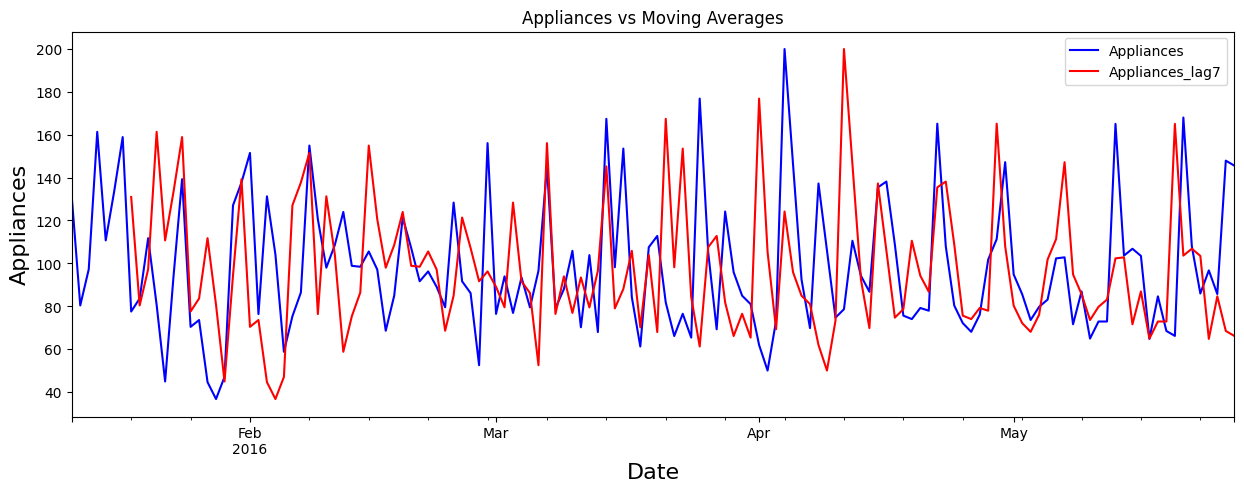

In [1563]:
# comparing 'Appliances' with feature engineered moving averages

df_iot[['Appliances','Appliances_lag7']].plot(figsize=(15, 5), title='Appliances vs Moving Averages',color=['blue', 'red', 'green'])
plt.xlabel('Date', fontsize=16)
plt.ylabel('Appliances', fontsize=16)
plt.show()

In [1564]:
# larger moving average window for Appliances lagged by 1 day
df_iot['Appliances_lag1_roll_mean7'] = df_iot['Appliances'].shift(1).rolling(window=7).mean()

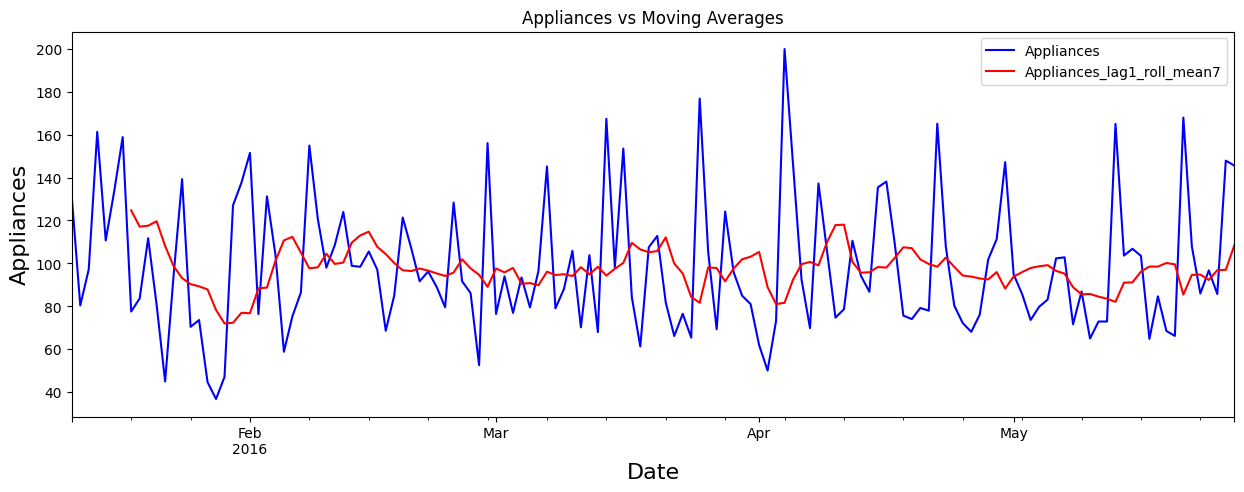

In [1565]:
df_iot[['Appliances','Appliances_lag1_roll_mean7']].plot(figsize=(15, 5), title='Appliances vs Moving Averages',color=['blue', 'red', 'green'])
plt.xlabel('Date', fontsize=16)
plt.ylabel('Appliances', fontsize=16)
plt.show()

In [1566]:
# larger moving average window for Appliances
df_iot['Appliances_roll_mean7'] = df_iot['Appliances'].shift(1).rolling(window=7).mean()
# larger moving average window for Appliances lagged by 7 day

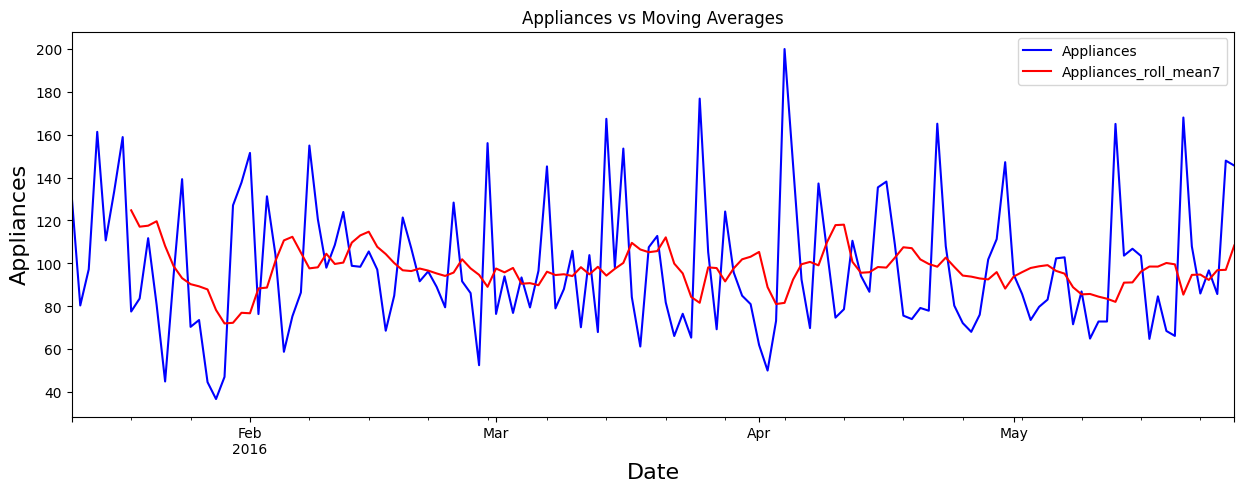

In [1567]:
df_iot[['Appliances', 'Appliances_roll_mean7']].plot(figsize=(15, 5), title='Appliances vs Moving Averages',color=['blue', 'red', 'green', 'orange'])
plt.xlabel('Date', fontsize=16)
plt.ylabel('Appliances', fontsize=16)
plt.legend(['Appliances', 'Appliances_roll_mean7', 'Appliances_lag7_roll_mean7', 'Appliances_lag14_roll_mean7'])
plt.show()


In [1568]:
# lower ewm
df_iot['Appliances_ewm1'] = df_iot['Appliances'].shift(1).ewm(com=0.4).mean()
# medium ewm

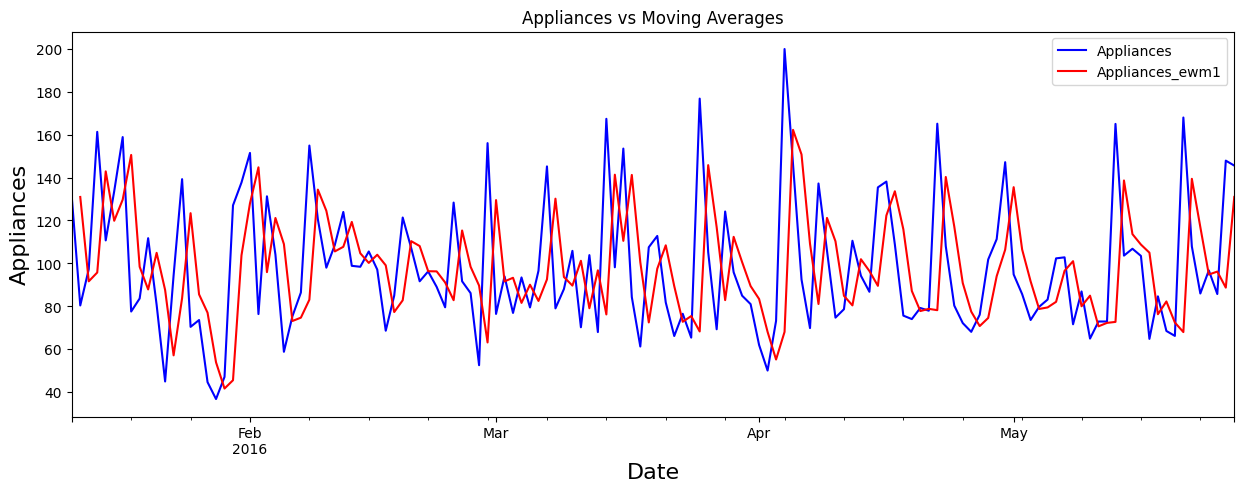

In [1569]:
df_iot[['Appliances', 'Appliances_ewm1']].plot(figsize=(15, 5), title='Appliances vs Moving Averages',color=['blue', 'red', 'green', 'orange'])
plt.xlabel('Date', fontsize=16)
plt.ylabel('Appliances', fontsize=16)
plt.legend(['Appliances', 'Appliances_ewm1', 'Appliances_ewm2', 'Appliances_ewm3'])
plt.show()

In [1570]:
# dropping null values
df_iot.dropna(inplace=True)

<Axes: >

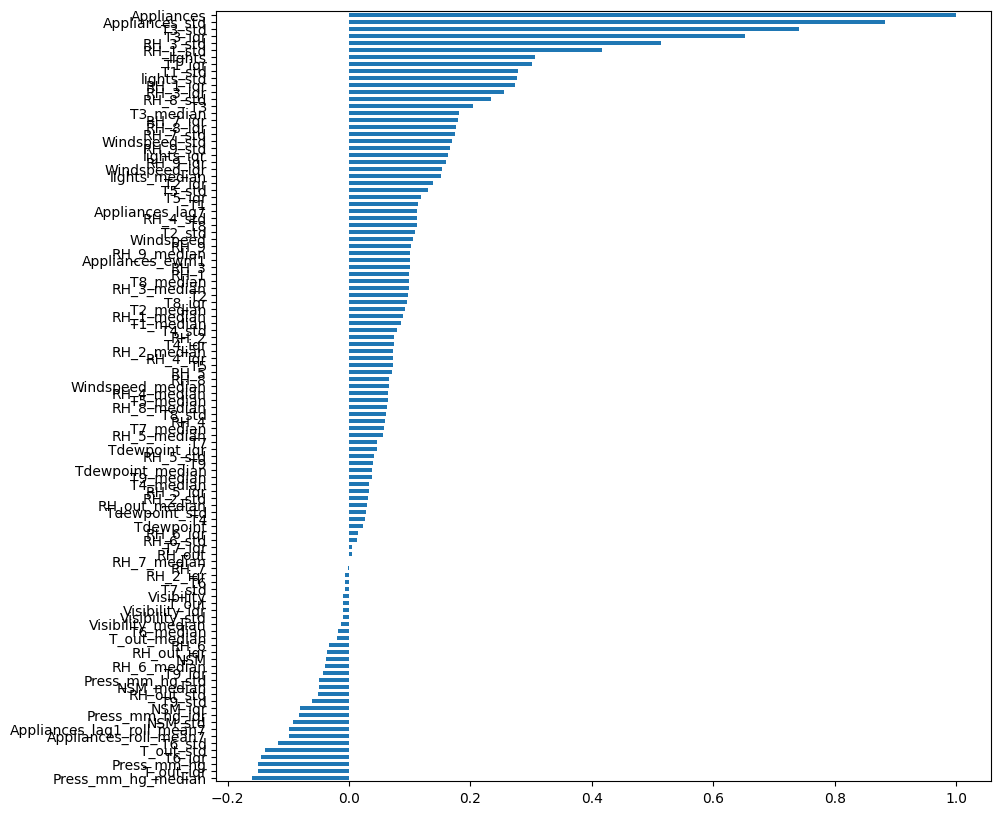

In [1571]:
#

df_iot.corr(method='spearman')['Appliances'].sort_values().plot(kind='barh',figsize=(10,10))

<Axes: >

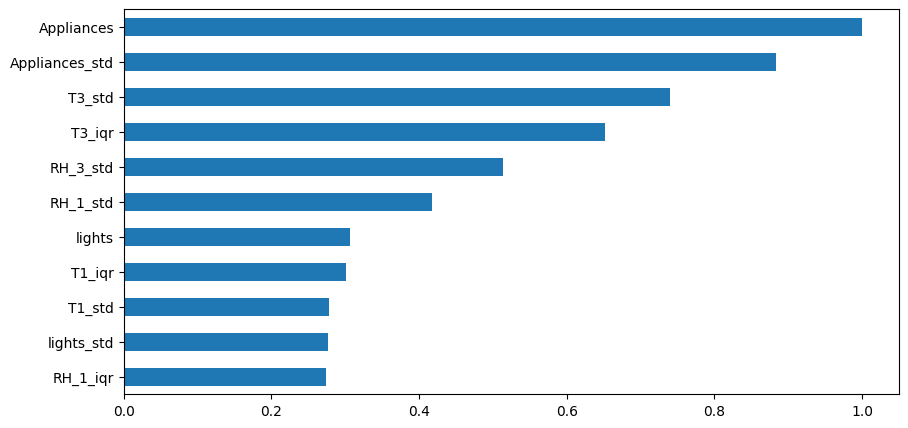

In [1572]:
np.abs(df_iot.corr(method='spearman'))['Appliances'].sort_values(ascending=False)[0:11].sort_values().plot(kind='barh',figsize=(10,5))

In [1573]:
# select the features with the highest correlation with Appliances
cols = list(np.abs(df_iot.corr(method='spearman'))['Appliances'].sort_values(ascending=False)[:11].index)

In [1574]:
df_iot = df_iot[cols]

In [1575]:
df_iot[cols]

,Appliances,Appliances_std,T3_std,T3_iqr,RH_3_std,RH_1_std,lights,T1_iqr,T1_std,lights_std,RH_1_iqr
date,,,,,,,,,,,
2016-01-18,77.523810,120.038303,0.389173,0.560000,1.246725,0.838875,3.238095,1.200000,0.743122,6.122977,0.700000
2016-01-19,83.603604,115.921547,0.407748,0.725000,0.749857,0.699425,2.702703,0.700000,0.461354,5.712179,1.200000
2016-01-20,111.711712,114.335025,0.485108,0.711667,1.388952,1.751064,5.945946,1.333333,0.806227,10.390413,2.208333
2016-01-21,80.630631,94.554258,0.623597,0.485000,1.081949,2.015157,4.144144,1.623333,0.933054,7.194501,1.500000
2016-01-22,44.909091,42.138815,0.425021,0.832500,0.368119,1.229480,0.727273,0.600000,0.671594,2.939478,2.114167
...,...,...,...,...,...,...,...,...,...,...,...
2016-05-23,85.925926,85.128128,0.310376,0.600000,1.034862,1.227615,2.129630,0.582500,0.442115,6.121958,1.319167
2016-05-24,96.700000,56.533801,0.318191,0.300000,1.550138,2.098416,4.800000,0.400000,0.250141,9.043107,3.510000
2016-05-25,85.675676,59.031912,0.232557,0.274199,1.026247,1.142660,2.792793,0.802100,0.406499,7.156837,2.166667


In [1576]:
df_iot['day'] = df_iot.reset_index(drop=False)['date'].dt.weekday.values
# do the same for day of month
df_iot['month'] = df_iot.reset_index(drop=False)['date'].dt.month.values
# make a feature such that each week is represented by a number
df_iot['week'] = df_iot.reset_index(drop=False)['date'].dt.isocalendar().week.values

In [1577]:
df_iot['week']

date
2016-01-18     3
2016-01-19     3
2016-01-20     3
2016-01-21     3
2016-01-22     3
              ..
2016-05-23    21
2016-05-24    21
2016-05-25    21
2016-05-26    21
2016-05-27    21
Freq: D, Name: week, Length: 131, dtype: UInt32

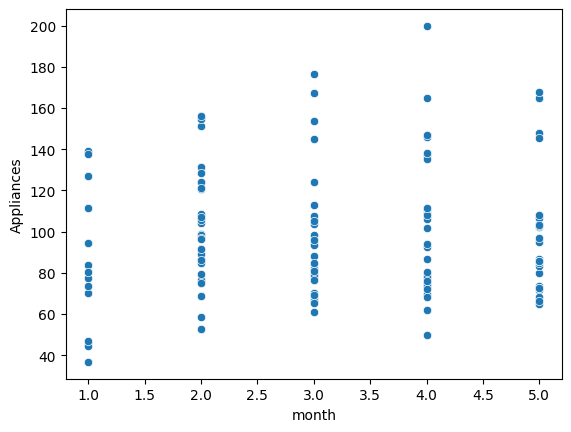

In [1578]:
sns.scatterplot(x='month', y='Appliances', data=df_iot)
plt.show()

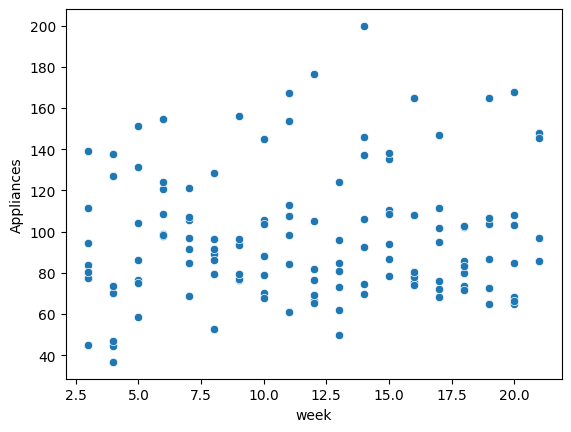

In [1579]:
sns.scatterplot(x='week', y='Appliances', data=df_iot)
plt.show()

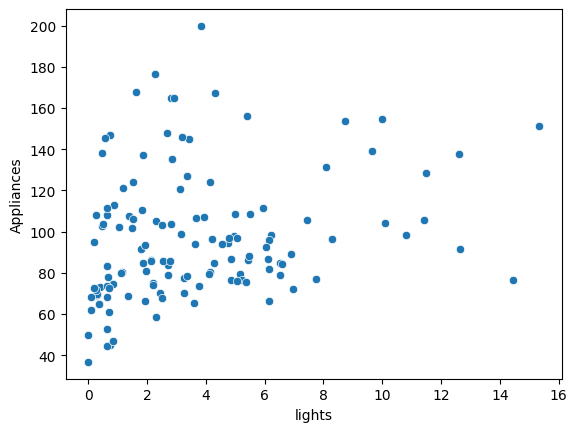

In [1580]:
sns.scatterplot(x='lights', y='Appliances', data=df_iot)
plt.show()

In [ ]:
# Split features and target variable
df_iot.drop('Appliances_std', axis=1,inplace=True)
#df_iot.drop('Appliances_std_quad', axis=1,inplace=True)


In [1607]:

X = df_iot.drop('Appliances', axis=1).reset_index(drop=True)
y = df_iot['Appliances'].reset_index(drop=True)
# created quadratic features from X
X_quad = X**2
X_quad.columns = [str(col)+'_quad' for col in X.columns]
print(X_quad)
X = pd.concat([X, X_quad], axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.01,shuffle=False)
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler
scaler = MinMaxScaler()
cols_scaler = list(X_train.columns)
X_train = pd.DataFrame(scaler.fit_transform(X_train),columns=cols_scaler)
X_valid = pd.DataFrame(scaler.transform(X_valid),columns=cols_scaler)

     T3_std_quad  T3_iqr_quad  RH_3_std_quad  RH_1_std_quad  lights_quad  \
0       0.151456     0.313600       1.554323       0.703711    10.485261   
1       0.166259     0.525625       0.562285       0.489196     7.304602   
2       0.235330     0.506469       1.929187       3.066225    35.354273   
3       0.388874     0.235225       1.170615       4.060858    17.173931   
4       0.180643     0.693056       0.135511       1.511621     0.528926   
..           ...          ...            ...            ...          ...   
126     0.096333     0.360000       1.070939       1.507038     4.535322   
127     0.101245     0.090000       2.402927       4.403349    23.040000   
128     0.054083     0.075185       1.053183       1.305672     7.799692   
129     1.336435     4.063453       0.860021       2.746898     7.210219   
130     0.828515     2.151111       1.445934       1.743661     0.322831   

     T1_iqr_quad  T1_std_quad  lights_std_quad  RH_1_iqr_quad  day_quad  \
0       1.44

In [1608]:
X

,T3_std,T3_iqr,RH_3_std,RH_1_std,lights,T1_iqr,T1_std,lights_std,RH_1_iqr,day,...,RH_3_std_quad,RH_1_std_quad,lights_quad,T1_iqr_quad,T1_std_quad,lights_std_quad,RH_1_iqr_quad,day_quad,month_quad,week_quad
0,0.389173,0.560000,1.246725,0.838875,3.238095,1.200000,0.743122,6.122977,0.700000,0,...,1.554323,0.703711,10.485261,1.440000,0.552230,37.490842,0.490000,0,1,9
1,0.407748,0.725000,0.749857,0.699425,2.702703,0.700000,0.461354,5.712179,1.200000,1,...,0.562285,0.489196,7.304602,0.490000,0.212848,32.628993,1.440000,1,1,9
2,0.485108,0.711667,1.388952,1.751064,5.945946,1.333333,0.806227,10.390413,2.208333,2,...,1.929187,3.066225,35.354273,1.777778,0.650001,107.960688,4.876736,4,1,9
3,0.623597,0.485000,1.081949,2.015157,4.144144,1.623333,0.933054,7.194501,1.500000,3,...,1.170615,4.060858,17.173931,2.635211,0.870589,51.760852,2.250000,9,1,9
4,0.425021,0.832500,0.368119,1.229480,0.727273,0.600000,0.671594,2.939478,2.114167,4,...,0.135511,1.511621,0.528926,0.360000,0.451038,8.640534,4.469701,16,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,0.310376,0.600000,1.034862,1.227615,2.129630,0.582500,0.442115,6.121958,1.319167,0,...,1.070939,1.507038,4.535322,0.339306,0.195466,37.478366,1.740201,0,25,441
127,0.318191,0.300000,1.550138,2.098416,4.800000,0.400000,0.250141,9.043107,3.510000,1,...,2.402927,4.403349,23.040000,0.160000,0.062570,81.777778,12.320100,1,25,441
128,0.232557,0.274199,1.026247,1.142660,2.792793,0.802100,0.406499,7.156837,2.166667,2,...,1.053183,1.305672,7.799692,0.643364,0.165241,51.220311,4.694444,4,25,441
129,1.156043,2.015801,0.927373,1.657377,2.685185,0.600000,0.306452,6.500393,2.387002,3,...,0.860021,2.746898,7.210219,0.360000,0.093913,42.255106,5.697779,9,25,441


In [1609]:
#model = XGBRegressor(n_estimators=50, random_state=42,
#                            learning_rate=0.11,max_depth=5)
model = SVR(kernel='rbf',degree=3,C=200.1,gamma=2.05, epsilon=0.5)
from sklearn.tree import DecisionTreeRegressor
#model = DecisionTreeRegressor(random_state=42,max_depth=20)
#model = RandomForestRegressor(n_estimators=50, random_state=42,max_depth=20,min_samples_split=5,min_samples_leaf=2)
#model = GradientBoostingRegressor(n_estimators=10, random_state=42, learning_rate=0.1, max_depth=10)
# polynomial features
from sklearn.linear_model import LinearRegression
#model = LinearRegression()

# do the training and validation split
model.fit(X_train, y_train)

# Evaluate model with selected features
y_pred_selected = model.predict(X_train)
mse_selected = mean_squared_error(y_train, y_pred_selected)
r2_selected = r2_score(y_train, y_pred_selected)

#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import classification_report

#print(confusion_matrix(y,y_pred_selected))
#print(classification_report(y,y_pred_selected))

#print(f"\nRandom Forest with Selected Features Performance:")
print(f"Mean Squared Error: {mse_selected:.2f}")
print(f"R² Score: {r2_selected:.2f}")
#print(f"RMSE: {np.sqrt(mse_selected):.2f}")


Mean Squared Error: 3.24
R² Score: 1.00


<Axes: title={'center': 'Appliances energy consumption'}>

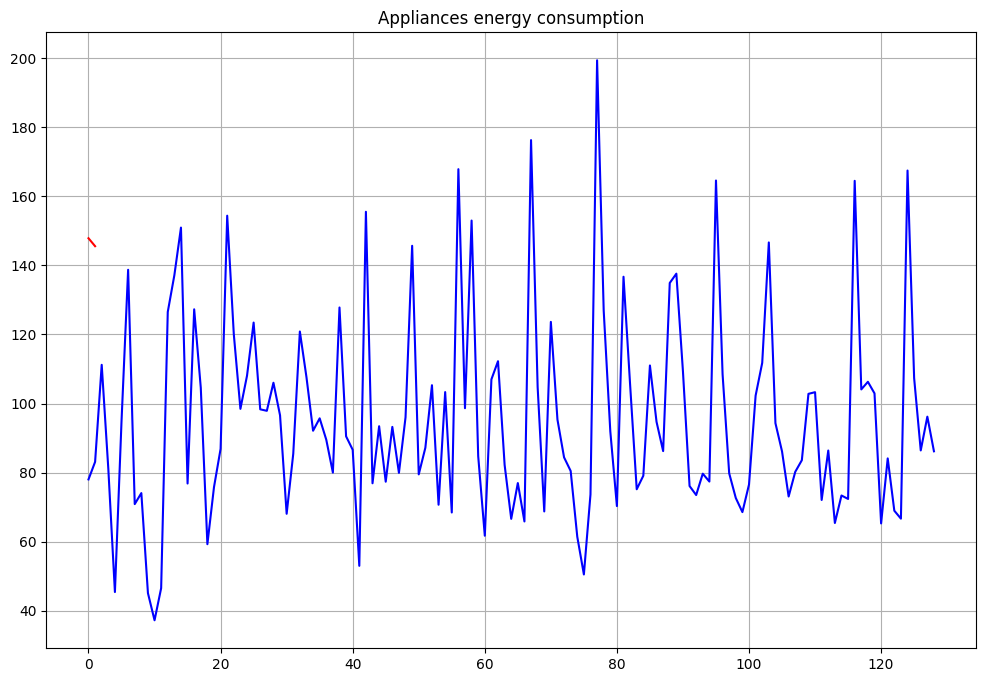

In [1610]:
pd.Series(y_pred_selected).plot(figsize=(12,8), grid=True, color='blue', title='Appliances energy consumption')
pd.Series(y_valid.reset_index(drop=True)).plot(figsize=(12,8), grid=True, color='red', title='Appliances energy consumption')

0

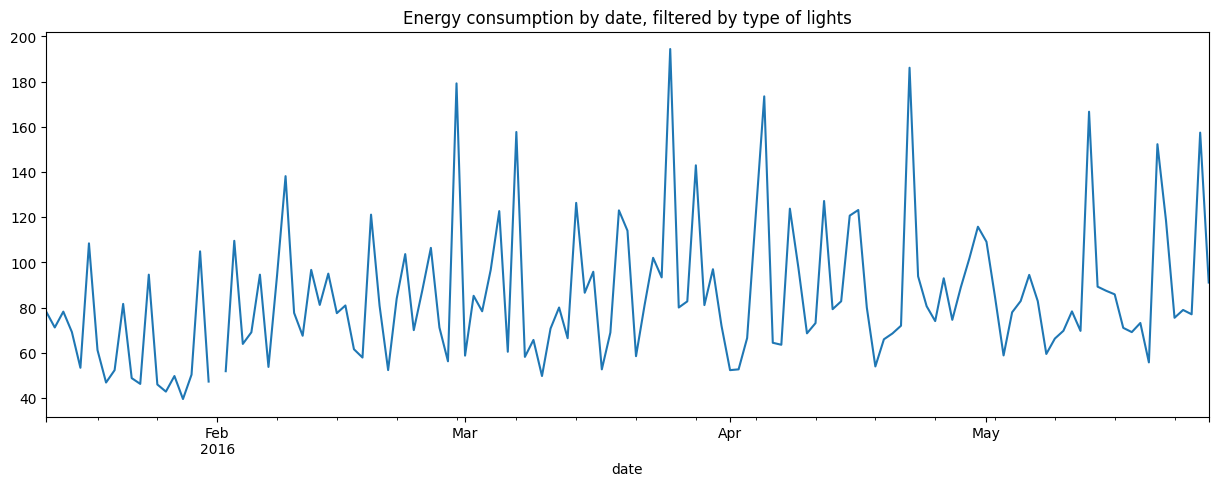

In [1611]:
df_iot_teste = pd.read_csv('projeto8-data_files/projeto8-testing.csv')
df_iot_teste['date'] = pd.to_datetime(df_iot_teste['date'])
df_iot_teste[df_iot_teste['lights']==0].set_index('date')['Appliances'].resample('D').mean().plot(figsize=(15, 5), title='Energy consumption by date, filtered by type of lights')
df_iot_teste.isnull().sum().sum()

In [1612]:
# let us wipe out random variables, rv1 and rv2, as well as 'Day_of_week' and 'WeekStatus'
df_iot_teste.drop(['rv1', 'rv2', 'Day_of_week', 'WeekStatus'], axis=1, inplace=True)
# transforming 'date' to datetime
df_iot_teste['date'] = pd.to_datetime(df_iot_teste['date'])
# let us begin by modeling just 'lights' == 0
#df_iot_teste = df_iot_teste[df_iot_teste['lights']==0].sort_values(by='date')
#df_iot_teste = df_iot_teste[df_iot_teste['lights'].isin([0,10,20])].sort_values(by='date')
#df_iot_teste.drop('lights', axis=1, inplace=True)
df_iot_teste_std = df_iot_teste.copy()
df_iot_teste_median = df_iot_teste.copy()
df_iot_teste_iqr = df_iot_teste.copy()
df_iot_teste = df_iot_teste.set_index('date').resample('D').mean()
# do the for the standard deviation
df_iot_teste_std = df_iot_teste_std.set_index('date').resample('D').std()
# renaming the columns
df_iot_teste_std.columns = [col+'_std' for col in df_iot_teste_std.columns]
# concatenating the mean and std
df_iot_teste = pd.concat([df_iot_teste, df_iot_teste_std], axis=1)
# do the for median
df_iot_teste_median = df_iot_teste_median.drop(columns=['Appliances']).set_index('date').resample('D').median()
# renaming the columns
df_iot_teste_median.columns = [col+'_median' for col in df_iot_teste_median.columns]
# concatenating the mean and std
df_iot_teste = pd.concat([df_iot_teste, df_iot_teste_median], axis=1)
# do the same for interquartile range
df_iot_teste_iqr = df_iot_teste_iqr.drop('Appliances',axis=1).set_index('date').resample('D').quantile(0.75) - df_iot_teste_iqr.drop('Appliances',axis=1).set_index('date').resample('D').quantile(0.25)
# renaming the columns
df_iot_teste_iqr.columns = [col+'_iqr' for col in df_iot_teste_iqr.columns]
# concatenating the mean and std
df_iot_teste = pd.concat([df_iot_teste, df_iot_teste_iqr], axis=1)
# moving average for Appliances lagged by 1 day
df_iot_teste['Appliances_lag7'] = df_iot_teste['Appliances'].shift(7)
# larger moving average window for Appliances lagged by 1 day
df_iot_teste['Appliances_lag1_roll_mean7'] = df_iot_teste['Appliances'].shift(1).rolling(window=7).mean()
# larger moving average window for Appliances lagged by 7 day
# lower ewm
df_iot_teste['Appliances_ewm1'] = df_iot_teste['Appliances'].shift(1).ewm(com=0.4).mean()
# dropping null values
df_iot_teste.dropna(inplace=True)
# select the features with the highest correlation with Appliances
df_iot_teste = df_iot_teste[cols]
df_iot_teste['day'] = df_iot_teste.reset_index(drop=False)['date'].dt.weekday.values
# do the same for day of month
df_iot_teste['month'] = df_iot_teste.reset_index(drop=False)['date'].dt.month.values
# make a feature such that each week is represented by a number
df_iot_teste['week'] = df_iot_teste.reset_index(drop=False)['date'].dt.isocalendar().week.values

df_iot_teste.drop('Appliances_std', axis=1,inplace=True)
#df_iot_teste.drop('Appliances_quad', axis=1,inplace=True)

X_teste = df_iot_teste.drop('Appliances', axis=1).reset_index(drop=True)
y_teste = np.round(df_iot_teste['Appliances'].reset_index(drop=True))

X_quad = X_teste**2
X_quad.columns = [str(col)+'_quad' for col in X_teste.columns]
X_teste = pd.concat([X_teste, X_quad], axis=1)

cols_scaler = list(X_teste.columns)
X_teste = pd.DataFrame(scaler.transform(X_teste),columns=cols_scaler)
# Evaluate model with selected features
y_pred_teste = np.round(model.predict(X_teste))

#y_pred_teste = pd.Series(y_pred_teste).apply(lambda x: 1 if x > 0.5 else 0)
mse_teste = mean_squared_error(y_teste, y_pred_teste)
r2_teste = r2_score(y_teste, y_pred_teste)

print(f"\nRandom Forest with Selected Features Performance:")
print(f"Mean Squared Error: {mse_teste:.2f}")
print(f"R² Score: {r2_teste:.2f}")
print(f"RMSE: {np.sqrt(mse_teste):.2f}")




Random Forest with Selected Features Performance:
Mean Squared Error: 435.52
R² Score: 0.60
RMSE: 20.87


<Axes: title={'center': 'Appliances energy consumption'}>

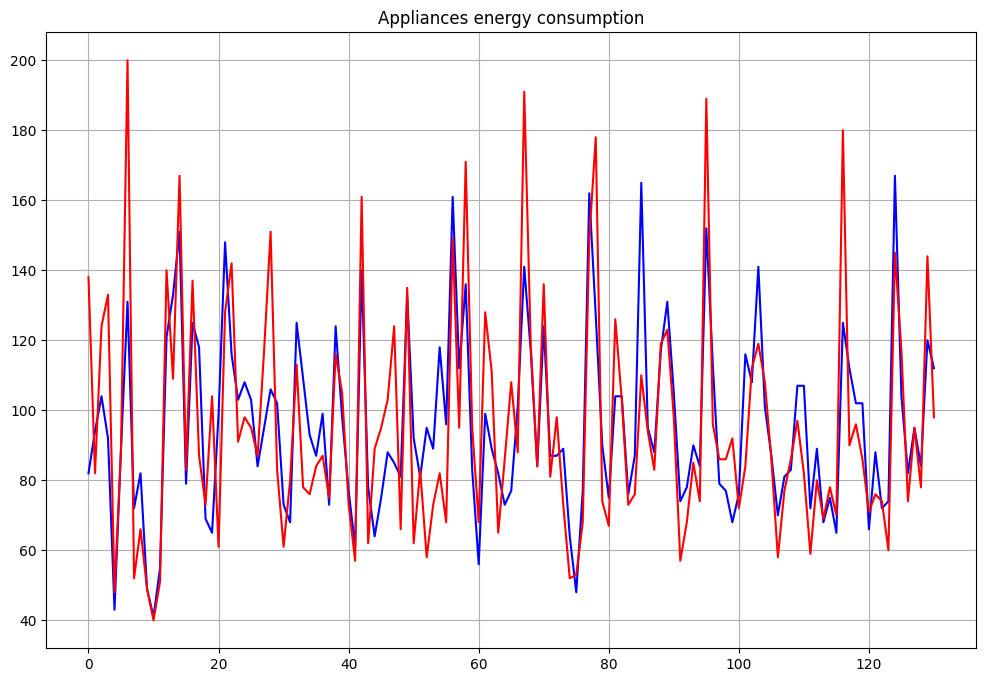

In [1613]:
pd.Series(y_pred_teste).plot(figsize=(12,8), grid=True, color='blue', title='Appliances energy consumption')
pd.Series(y_teste).plot(figsize=(12,8), grid=True, color='red', title='Appliances energy consumption')

In [1614]:
df_iot_teste

,Appliances,T3_std,T3_iqr,RH_3_std,RH_1_std,lights,T1_iqr,T1_std,lights_std,RH_1_iqr,day,month,week
date,,,,,,,,,,,,,
2016-01-18,138.205128,0.403420,0.450000,1.270749,0.761607,3.846154,0.810000,0.599015,5.900662,0.368333,0,1,3
2016-01-19,82.121212,0.520218,0.700000,0.876143,0.623717,2.727273,0.390000,0.328233,5.167644,1.103333,1,1,3
2016-01-20,123.636364,0.542903,0.800000,1.560146,1.583481,5.454545,1.243333,0.771515,9.045340,1.633333,2,1,3
2016-01-21,133.030303,0.679621,0.590000,1.284610,1.068098,3.939394,1.690000,1.009368,7.881701,1.390000,3,1,3
2016-01-22,48.235294,0.455141,0.760000,0.359996,1.111265,0.588235,0.835000,0.785596,2.388326,1.640833,4,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-23,74.444444,0.280769,0.390000,0.883053,1.279283,1.666667,0.615000,0.419165,5.606119,1.690833,0,5,21
2016-05-24,95.000000,0.345451,0.690000,1.705785,2.278826,2.954545,0.445000,0.242153,7.014784,4.275833,1,5,21
2016-05-25,77.878788,0.243709,0.433333,1.085112,1.128294,1.818182,0.637662,0.383488,6.351449,2.126667,2,5,21


/tmp/ipykernel_109968/4137527477.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(result.importances[sorted_idx].T,


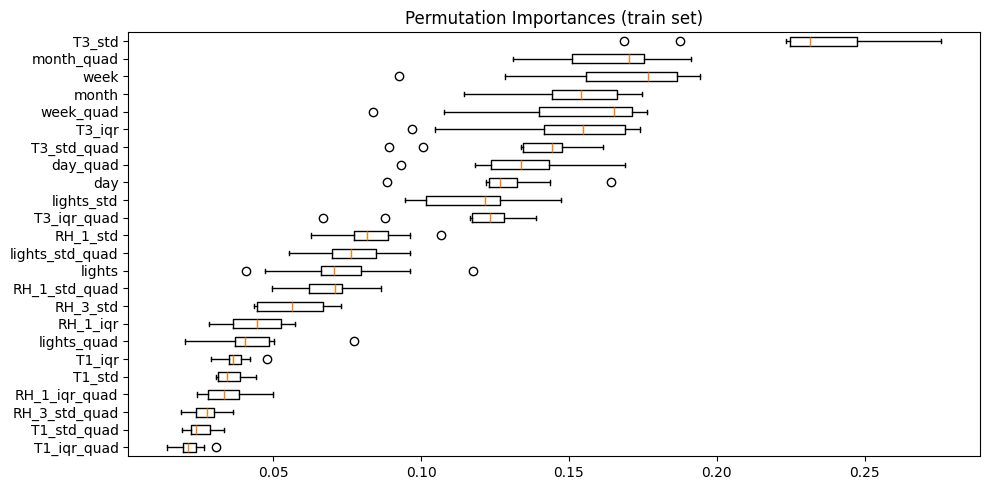

In [1615]:
# plot the feature importances for Support Vector Regressor using the permutation method
from sklearn.inspection import permutation_importance
result = permutation_importance(model, X_train, y_train, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(10, 5))
ax.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=X_train.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()


In [1590]:
# plot the feature importances for Support Vector Regressor


importances = model.coef_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,8))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X_train.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()


AttributeError: coef_ is only available when using a linear kernel